# Improving energy estimation of a Fermionic lattice model with SQD

In this tutorial we implement a [Qiskit pattern](https://docs.quantum.ibm.com/guides/intro-to-patterns) showing how to post-process noisy quantum samples to find an approximation to the ground state of a Fermionic lattice Hamiltonian known as the single-impurity Anderson model. We will follow a sample-based quantum diagonalization approach to process samples taken from a set of ``16``-qubit Krylov basis states over increasing time intervals. These states are realized on the quantum device using Trotterization of the time evolution. In order to account for the effect of quantum noise, the configuration recovery technique is used. Assuming a good initial state and sparsity of the ground state, [this approach is proven to converge efficiently](https://arxiv.org/abs/2501.09702).

The pattern can be described in four steps:

1. **Step 1: Map to quantum problem**
    - Generate a set of Krylov basis states (i.e., Trotterized time-evolution circuits) over increasing time intervals for estimating the ground state
2. **Step 2: Optimize the problem**
    - Transpile the circuits for the backend
3. **Step 3: Execute experiments**
    - Draw samples from the circuits using the ``Sampler`` primitive
4. **Step 4: Post-process results**
   - Self-consistent configuration recovery loop
       - Post-process the full set of bitstring samples, using prior knowledge of particle number and the average orbital occupancy calculated on the most recent iteration
       - Probabilistically create batches of subsamples from recovered bitstrings
       - Project and diagonalize the Fermionic lattice Hamiltonian over each sampled subspace
       - Save the minimum ground state energy found across all batches and update the avg orbital occupancy

### Step 1: Map problem to a quantum circuit

First, we will create the one- and two-body Hamiltonians describing the one-dimensional single-impurity Anderson model (SIAM) with ``7`` bath sites (``8`` electrons in ``8`` orbitals). This model is used to describe magnetic impurities embedded in metals.

Then we will create the ``16``-qubit Trotter circuits used to generate the quantum Krylov subspace.

In [1]:
import numpy as np

n_bath = 7  # number of bath sites

V = 1  # hybridization amplitude
t = 1  # bath hopping amplitude
U = 10  # Impurity onsite repulsion
eps = -U / 2  # Chemical potential for the impurity

# Place the impurity on the first qubit
impurity_index = 0

# One body matrix elements in the "position" basis
h1e = -t * np.diag(np.ones(n_bath), k=1) - t * np.diag(np.ones(n_bath), k=-1)
h1e[impurity_index, impurity_index + 1] = -V
h1e[impurity_index + 1, impurity_index] = -V
h1e[impurity_index, impurity_index] = eps

# Two body matrix elements in the "position" basis
h2e = np.zeros((n_bath + 1, n_bath + 1, n_bath + 1, n_bath + 1))
h2e[impurity_index, impurity_index, impurity_index, impurity_index] = U

Next, we will generate the quantum Krylov subspace with a set of Trotterized quantum circuits. Here we create helpers for generating the initial (reference) state as well as the time evolution for the one- and two-body parts of the Hamiltonian. For a more detailed description of this model and how the circuits are designed, please refer to [the paper](https://arxiv.org/abs/2501.09702).

In [2]:
import ffsim
import scipy
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import CPhaseGate, XGate, XXPlusYYGate

n_modes = n_bath + 1
nelec = (n_modes // 2, n_modes // 2)

dt = 0.2
Utar = scipy.linalg.expm(-1j * dt * h1e)


# The reference state
def initial_state(q_circuit, norb, nocc):
    """Prepare an initial state."""
    for i in range(nocc):
        q_circuit.append(XGate(), [i])
        q_circuit.append(XGate(), [norb + i])
    rot = XXPlusYYGate(np.pi / 2, -np.pi / 2)

    for i in range(3):
        for j in range(nocc - i - 1, nocc + i, 2):
            q_circuit.append(rot, [j, j + 1])
            q_circuit.append(rot, [norb + j, norb + j + 1])
    q_circuit.append(rot, [j + 1, j + 2])
    q_circuit.append(rot, [norb + j + 1, norb + j + 2])


# The one-body time evolution
free_fermion_evolution = ffsim.qiskit.OrbitalRotationJW(n_modes, Utar)


# The two-body time evolution
def append_diagonal_evolution(dt, U, impurity_qubit, num_orb, q_circuit):
    """Append two-body time evolution to a quantum circuit."""
    if U != 0:
        q_circuit.append(
            CPhaseGate(-dt / 2 * U),
            [impurity_qubit, impurity_qubit + num_orb],
        )

Generate ``d`` time-evolved states that specify the quantum Krylov subspace. Here, we have chosen ``d=8``. The error from sampling Krylov basis states converges with increasing ``d``. Note that the particulars of this problem instance allow for an efficient compilation of the one-body evolution using `OrbitalRotationJW`; however, in general, one could use Qiskit's [PauliEvolutionGate](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.PauliEvolutionGate) to implement the Trotterized time evolution of the full Hamiltonian.

In [3]:
# Generate the initial state
qubits = QuantumRegister(2 * n_modes, name="q")
init_state = QuantumCircuit(qubits)
initial_state(init_state, n_modes, n_modes // 2)
init_state.draw("mpl", scale=0.4, fold=-1)

d = 8  # Number of Krylov basis states
circuits = []
for i in range(d):
    circ = init_state.copy()
    circuits.append(circ)
    for _ in range(i):
        append_diagonal_evolution(dt, U, impurity_index, n_modes, circ)
        circ.append(free_fermion_evolution, qubits)
        append_diagonal_evolution(dt, U, impurity_index, n_modes, circ)
    circ.measure_all()

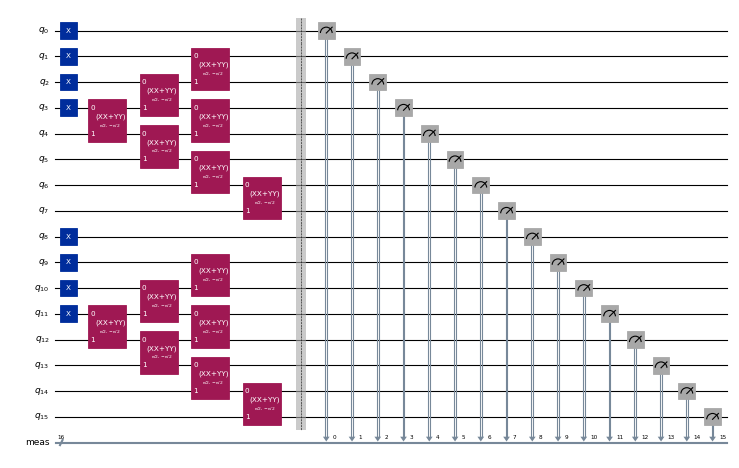

In [4]:
circuits[0].draw("mpl", scale=0.4, fold=-1)

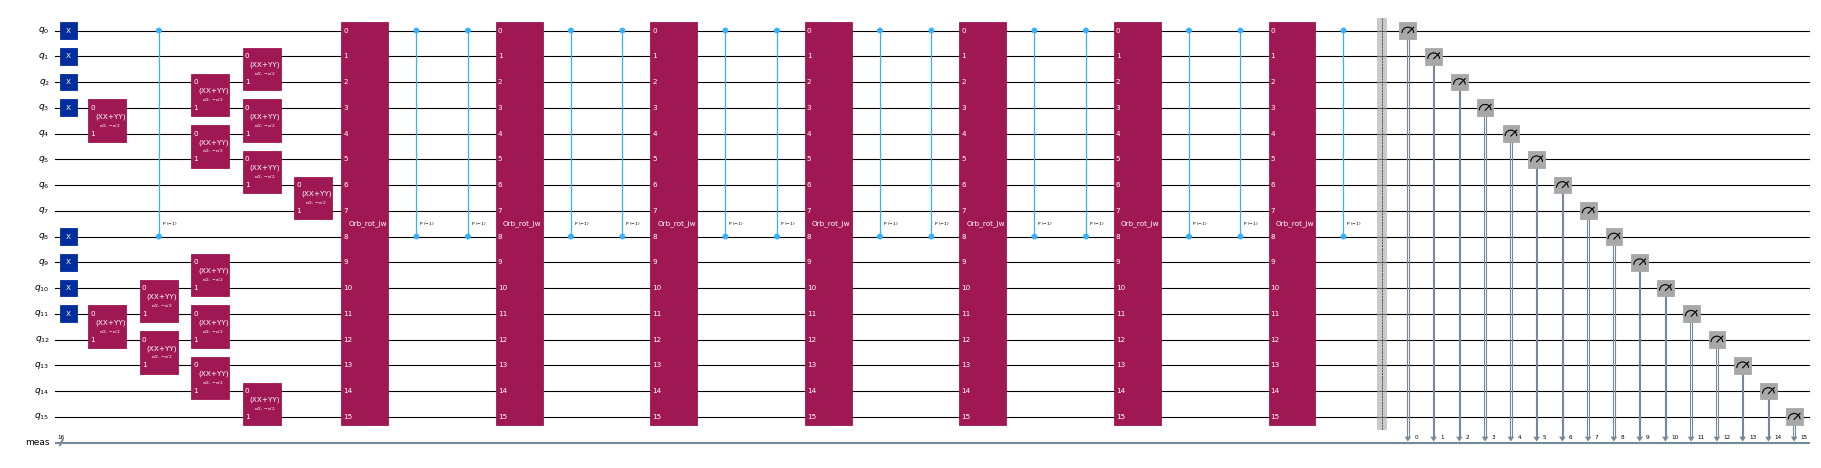

In [5]:
circuits[-1].draw("mpl", scale=0.4, fold=-1)

### Step 2: Optimize the problem

After we have created the Trotterized circuits, we will optimize them for a target hardware. We need to choose the hardware device to use before optimization. We will use a fake 127-qubit backend from ``qiskit_ibm_runtime`` to emulate a real device. To run on a real QPU, just replace the fake backend with a real backend. Check out the [Qiskit IBM Runtime docs](https://docs.quantum.ibm.com/guides/get-started-with-primitives#get-started-with-sampler) for more info.

In [6]:
from qiskit_ibm_runtime.fake_provider.backends import FakeSherbrooke

backend = FakeSherbrooke()

Next, we will transpile the circuits to the target backend using Qiskit.

In [7]:
from qiskit.transpiler import generate_preset_pass_manager

# The circuit needs to be transpiled to the AerSimulator target
pass_manager = generate_preset_pass_manager(optimization_level=3, backend=backend)
isa_circuits = pass_manager.run(circuits)

### Step 3: Execute experiments

After optimizing the circuits for hardware execution, we are ready to run them on the target hardware and collect samples for ground state energy estimation. Here we use ``SamplerV2`` from ``qiskit-ibm-runtime`` to simulate noisy samples taken from the ``ibm_sherbrooke`` backend. We then combine the counts from each of the Krylov basis states into a single counts dictionary and plot the top 20 most commonly sampled bitstrings.

***Note: [Qiskit Aer](https://qiskit.github.io/qiskit-aer/index.html) is required to simulate samples from transpiled circuits.***

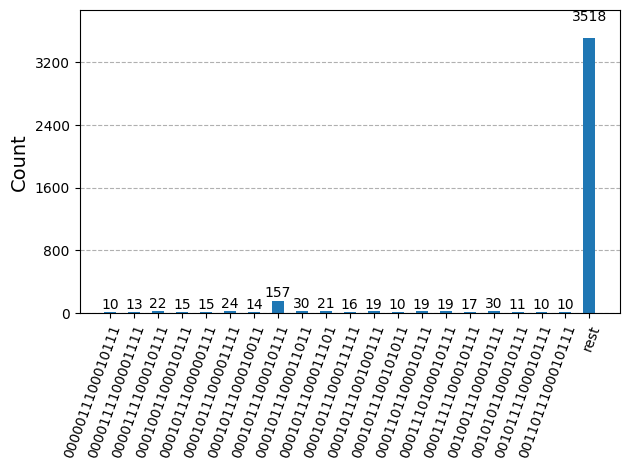

In [8]:
from qiskit.primitives import BitArray
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import SamplerV2 as Sampler

# Sample from the circuits
noisy_sampler = Sampler(backend, options={"simulator": {"seed_simulator": 24}})
job = noisy_sampler.run(isa_circuits, shots=500)

# Combine the counts from the individual Trotter circuits
bit_array = BitArray.concatenate_shots([result.data.meas for result in job.result()])

plot_histogram(bit_array.get_counts(), number_to_keep=20)

### Step 4: Post-process the results

The following code cell runs the SQD algorithm.

In [9]:
from qiskit_addon_sqd.fermion import SCIResult, run_sqd

# List to capture intermediate results
result_history = []


def callback(results: list[SCIResult]):
    result_history.append(results)
    iteration = len(result_history)
    print(f"Iteration {iteration}")
    for i, result in enumerate(results):
        print(f"\tSubsample {i}")
        print(f"\t\tEnergy: {result.energy}")
        print(f"\t\tSubspace dimension: {np.prod(result.sci_state.amplitudes.shape)}")


rng = np.random.default_rng(24)
result = run_sqd(
    h1e,
    h2e,
    bit_array,
    subsample_size=300,
    norb=n_modes,
    nelec=nelec,
    n_subsamples=3,
    max_iterations=10,
    symmetrize_spin=True,
    callback=callback,
    seed=rng,
)

Iteration 1
	Subsample 0
		Energy: -13.099856491278608
		Subspace dimension: 3600
	Subsample 1
		Energy: -13.099856491378011
		Subspace dimension: 3721
	Subsample 2
		Energy: -13.099304131807614
		Subspace dimension: 3481
Iteration 2
	Subsample 0
		Energy: -13.215503395349192
		Subspace dimension: 4225
	Subsample 1
		Energy: -13.395978954072845
		Subspace dimension: 4225
	Subsample 2
		Energy: -13.301174873178995
		Subspace dimension: 4096
Iteration 3
	Subsample 0
		Energy: -13.40815049272271
		Subspace dimension: 4624
	Subsample 1
		Energy: -13.41051632803399
		Subspace dimension: 4356
	Subsample 2
		Energy: -13.409015356281886
		Subspace dimension: 4489
Iteration 4
	Subsample 0
		Energy: -13.41051632803399
		Subspace dimension: 4356
	Subsample 1
		Energy: -13.414680264905417
		Subspace dimension: 4624
	Subsample 2
		Energy: -13.414680264905417
		Subspace dimension: 4624
Iteration 5
	Subsample 0
		Energy: -13.422367046563426
		Subspace dimension: 4761
	Subsample 1
		Energy: -13.422367

Now, we plot the results. The first plot shows that after a few iterations, we obtain the exact ground state energy.

This example is small enough that we are able to explore the full Hilbert space, as seen in the print statements above. Remember, the full Hilbert space is dimension ``(num_orbitals choose nelec_a) * (num_orbitals choose nelec_b)``. So for this problem: `(8 choose 4)**2 = 4900`. The subspace dimensions increase due enhanced configuration recovery, and also the fact that the SQD algorithm carries important configurations from one iteration to the next. By the last iteration, we are diagonalizing in the entire Hilbert space.

The second plot shows the average occupancy of each spatial orbital across all batches' solutions. We see that with high probability each orbital contains one electron.

Exact energy: -13.42249
SQD energy: -13.42249
Absolute error: 0.00000


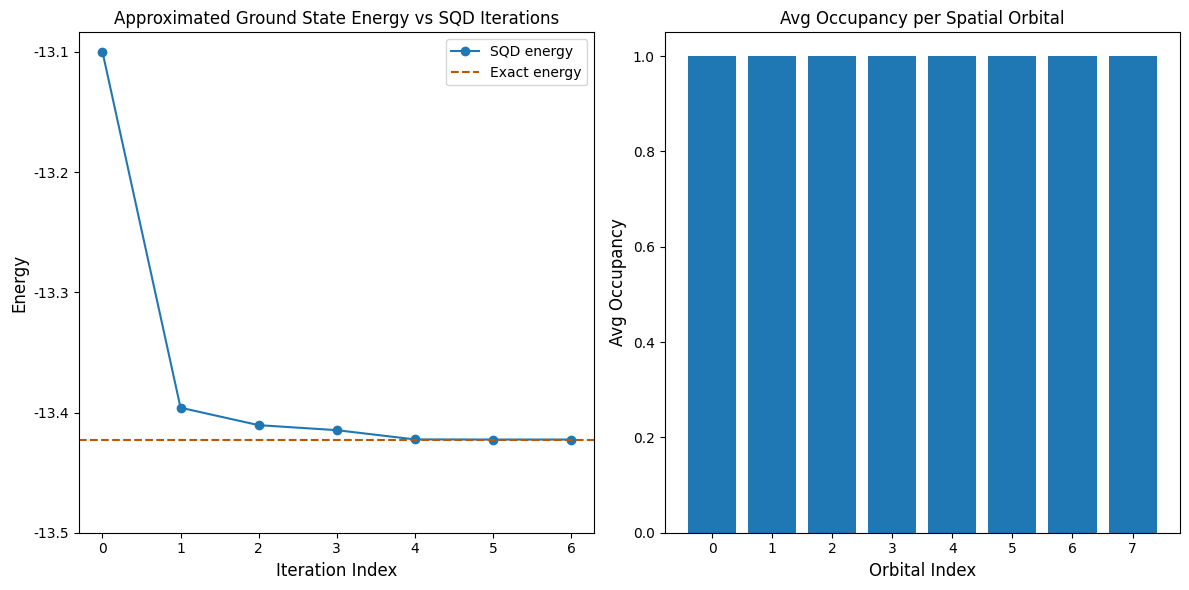

In [10]:
import matplotlib.pyplot as plt

exact_energy = -13.422491814605827
min_es = [min(result, key=lambda res: res.energy).energy for result in result_history]
min_id, min_e = min(enumerate(min_es), key=lambda x: x[1])

# Data for energies plot
x1 = range(len(result_history))
yt1 = list(np.arange(-13.5, -13.1, 0.1))
ytl = [f"{i:.1f}" for i in yt1]

# Data for avg spatial orbital occupancy
y2 = np.sum(result.orbital_occupancies, axis=0)
x2 = range(len(y2))

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot energies
axs[0].plot(x1, min_es, label="SQD energy", marker="o")
axs[0].set_xticks(x1)
axs[0].set_xticklabels(x1)
axs[0].set_yticks(yt1)
axs[0].set_yticklabels(ytl)
axs[0].axhline(y=exact_energy, color="#BF5700", linestyle="--", label="Exact energy")
axs[0].set_title("Approximated Ground State Energy vs SQD Iterations")
axs[0].set_xlabel("Iteration Index", fontdict={"fontsize": 12})
axs[0].set_ylabel("Energy", fontdict={"fontsize": 12})
axs[0].legend()

# Plot orbital occupancy
axs[1].bar(x2, y2, width=0.8)
axs[1].set_xticks(x2)
axs[1].set_xticklabels(x2)
axs[1].set_title("Avg Occupancy per Spatial Orbital")
axs[1].set_xlabel("Orbital Index", fontdict={"fontsize": 12})
axs[1].set_ylabel("Avg Occupancy", fontdict={"fontsize": 12})

print(f"Exact energy: {exact_energy:.5f}")
print(f"SQD energy: {min_e:.5f}")
print(f"Absolute error: {abs(min_e - exact_energy):.5f}")
plt.tight_layout()
plt.show()